# Fidelity Analysis for First Order Trotter 
In this notebook I provide the scripts that allow me to analize the digital-analog Heisenberg simulation and compare it against its digital counterpart. Now I focus on 2nd order Trotter.

TODO explain logic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

MAX = 1e9

## Single Step Analysis
TODO explain logic

In [2]:
def fidelityDigitalT2(N, args):
    return (args["F_1q"] ** args["N1D"](N)) * (args["F_Uq"] ** args["NUq"](N)) * (args["F_zz"] ** args["Nzz"](N))

def fidelityDAnalogT2(N, args):
    return (args["F_1q"] ** args["N1DA"](N)) * (args["F_xy"](N) ** args["Nxy"])

def color_gradient(start, end, n):
    """Generate n hex colors from start to end."""
    start_rgb = np.array(mcolors.to_rgb(start))
    end_rgb = np.array(mcolors.to_rgb(end))
    return [mcolors.to_hex(start_rgb + (end_rgb - start_rgb) * i/(n-1)) for i in range(n)]

def fidelityEvaluatorT2(values_N, args):
    fid_dig = np.zeros(len(values_N))
    fid_dan = np.zeros(len(values_N))
    fid_ratio = np.zeros(len(values_N))

    for N in values_N:
        fid_dig[N-values_N[0]] = fidelityDigitalT2(N, args)
        fid_dan[N-values_N[0]] = fidelityDAnalogT2(N, args)
        fid_ratio[N-values_N[0]] = fid_dan[N-values_N[0]] / fid_dig[N-values_N[0]] # NOTE: I look for F_DA / F_D > 1 s.t. F_DA > F_D

    return fid_dig, fid_dan, fid_ratio

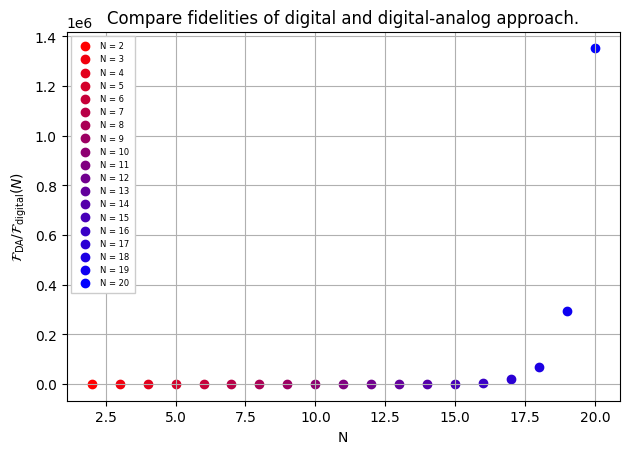

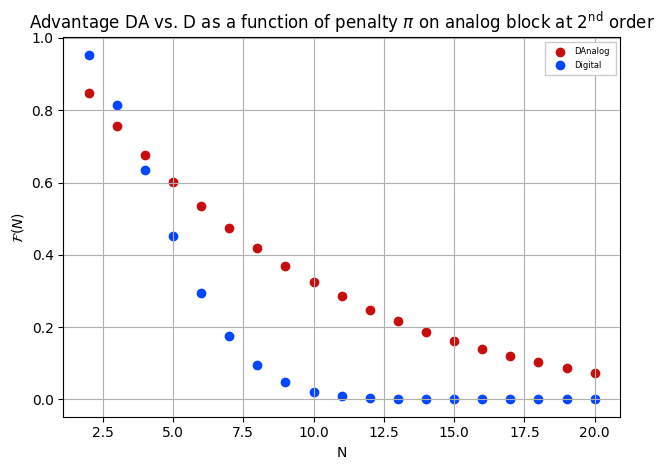

In [ ]:
params = {
    # fidelities
    "F_1q": 1-1e-3, # fidelity of 1q rotations gates
    "F_Uq": 1-1e-3, # fidelity of Uq gates
    "F_zz": 1-1e-2,  # fidelity of 2 qubit ZZ gates
    "F_xy": lambda N: 0.99 - 0.02*(N-1), # fidelity of analog XY gate
    # number of gates per single Trotter step
    "N1D" : lambda N: 3*N*(2*N-3)/2 + N,
    "N1DA": lambda N: 6*N + N,       
    "NUq" : lambda N: 6*N*(2*N-3),
    "Nzz" : lambda N: 3*N*(2*N-3)/2,
    "Nxy" : 5
}

N_max = 20
values_N = np.arange(2, N_max+1)

fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(values_N))

for N in values_N:
    ax.scatter(N, fidelityDAnalogT2(N, params)/fidelityDigitalT2(N, params), color=colors[N-2], label=f"N = {N}")

ax.set_title("Compare fidelities of digital and digital-analog approach.")
ax.set_xlabel("N")
ax.set_ylabel(r"$\mathcal{F}_\text{DA}/\mathcal{F}_\text{digital} (N)$")

legend = ax.legend(loc=2, frameon=True, borderaxespad=0.8, fontsize=6)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle("Square")

plt.grid()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", N_max-1)

fid_digital = np.zeros(len(values_N))
fid_danalog = np.zeros(len(values_N))

for N in values_N:
    fid_digital[N-2] = fidelityDigitalT2(N, params)
    fid_danalog[N-2] = fidelityDAnalogT2(N, params)

ax.scatter(values_N, fid_danalog, label="DAnalog", color="#C70E0E")
ax.scatter(values_N, fid_digital, label="Digital", color="#0346FF")

ax.set_title("Compare fidelities of digital and digital-analog approach.")
ax.set_xlabel("N")
ax.set_ylabel(r"$\mathcal{F}(N)$")

legend = ax.legend(loc=1, frameon=True, borderaxespad=0.8, fontsize=6)
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(1.0)
legend.get_frame().set_boxstyle("Square")

plt.grid()
plt.tight_layout()
plt.show()

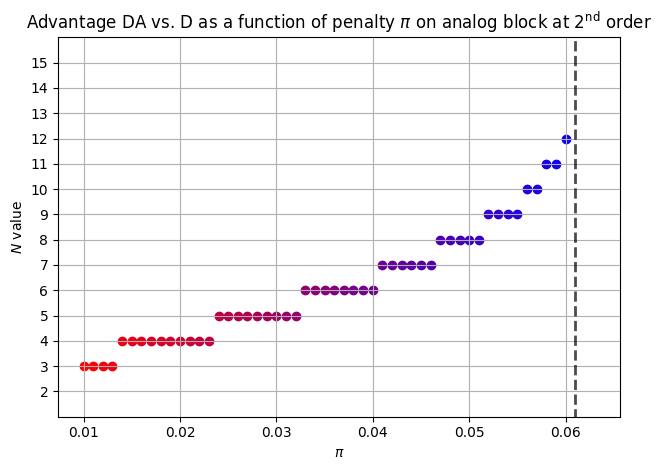

In [10]:
penalty_values = np.arange(10, 64) * 1e-3 

N_max = 15
values_N = np.arange(2, N_max+1)

if 0 in values_N or N_max <= 0: raise Exception("The choose values of N are not valid.")

values_N_advantage = []
idx_fail = MAX

for penalty in penalty_values:

    params = {
        # fidelities
        "F_1q": 1-1e-3, # fidelity of 1q rotations gates
        "F_Uq": 1-1e-3, # fidelity of Uq gates
        "F_zz": 1-1e-2,  # fidelity of 2 qubit ZZ gates
        "F_xy": lambda N: 0.99 - penalty*(N-1), # fidelity of analog XY gate
        # number of gates per single Trotter step
        "N1D" : lambda N: 3*N*(2*N-3)/2 + N,
        "N1DA": lambda N: 6*N + N,       
        "NUq" : lambda N: 6*N*(2*N-3),
        "Nzz" : lambda N: 3*N*(2*N-3)/2,
        "Nxy" : 5
    }

    _, _, fidelityRatio = fidelityEvaluatorT2(values_N, params)

    idx_max = MAX

    for i, value in enumerate(fidelityRatio): 
        if value >= 1 and idx_max > i: 
            values_N_advantage.append(i + values_N[0])
            idx_max = i

    if idx_max == MAX: values_N_advantage.append(-1)
    
fig, ax = plt.subplots()
colors = color_gradient("#ff0000", "#0000ff", len(penalty_values))      

for i, penalty in enumerate(penalty_values): ax.scatter(penalty, values_N_advantage[i], color=colors[i])

ax.set_title(r"Advantage DA vs. D as a function of penalty $\pi$ on analog block at $2^\text{nd}$ order")
ax.set_xlabel(r"$\pi$")
ax.set_ylabel(r"$N$ value")
ax.set_yticks(values_N)
ax.set_ylim((values_N[0]-1, values_N[-1]+1))

# if idx_fail != MAX:
#     x_pt = np.array([penalty_values[idx_fail],penalty_values[idx_fail]])
#     y_pt = np.array([1.9,values_N[-1]])
#     plt.plot(x_pt, y_pt, 'r-', linewidth=3, alpha=0.7)

x_pt = np.array([0.061,0.061])
y_pt = np.array([0.9,values_N[-1]+1])
plt.plot(x_pt, y_pt, '--', linewidth=2, alpha=0.7, color="#000000")

plt.grid()
plt.tight_layout()
plt.show()